# Snow model
*R.A. Collenteur, University of Graz / Eawag, November 2021*

In this notebook it is shown how to account for snowfall and smowmelt on groundwater recharge and groundwater levels, using a degree-day snow model. This notebook is work in progress and will be extended in the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions(numba=True)

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.3
Pandas version: 1.3.5
Pastas version: 0.20.0b
Matplotlib version: 3.5.0
numba version: 0.53.1


## 1. Load data
In this notebook we will look at some data for a well near Heby, Sweden. All the meteorological data is taken from the E-OBS database. As can be observed from the temperature time series, the temparature regularly drops below zero in winter. Given this observation, we may expect precipitation to (partially) fall as snow during these periods.

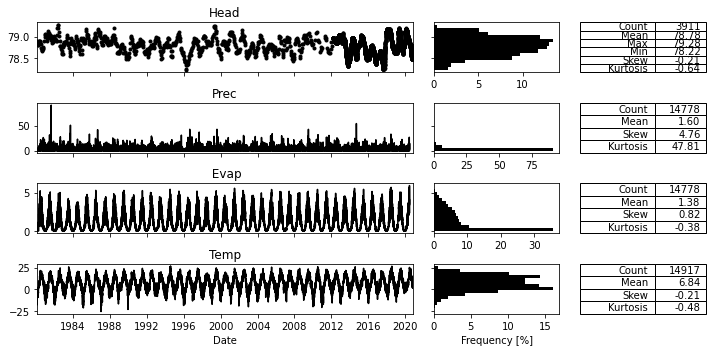

In [2]:
head = pd.read_csv("../data/heby_head.csv", index_col=0, parse_dates=True).squeeze()
evap = pd.read_csv("../data/heby_evap.csv", index_col=0, parse_dates=True).squeeze()
prec = pd.read_csv("../data/heby_prec.csv", index_col=0, parse_dates=True).squeeze()
temp = pd.read_csv("../data/heby_temp.csv", index_col=0, parse_dates=True).squeeze()

ps.plots.series(head=head, stresses=[prec, evap, temp]);

## 2. Make a simple model
First we create a simple model with precipitation and potential evaporation as input, using the non-linear `FlexModel` to compute the recharge flux. We not not yet take snowfall into account, and thus assume all precipitation occurs as snowfall. The model is calibrated and the results are visualized for inspection.

In [3]:
# Settings
tmin = "1985"  # Needs warmup
tmax = "2010"

Fit report Head                       Fit Statistics
nfev    31                     EVP             50.20
nobs    590                    R2               0.50
noise   True                   RMSE             0.12
tmin    1985-01-01 00:00:00    AIC          -3292.32
tmax    2010-01-01 00:00:00    BIC          -3261.65
freq    D                      Obj              1.09
warmup  3650 days 00:00:00     ___                  
solver  LeastSquares           Interp.            No

Parameters (7 optimized)
                 optimal   stderr     initial   vary
rch_A           0.787803   ±8.09%    0.577234   True
rch_n           1.147703   ±2.13%    2.444284   True
rch_a         250.281675   ±9.89%   82.690152   True
rch_srmax     123.656992    ±nan%  123.656992  False
rch_lp          0.250000    ±nan%    0.250000  False
rch_ks       1048.264017  ±38.69%  207.245712   True
rch_gamma       7.665438   ±8.64%    0.404457   True
rch_kv          0.597547   ±6.24%    0.900911   True
rch_simax       2.00

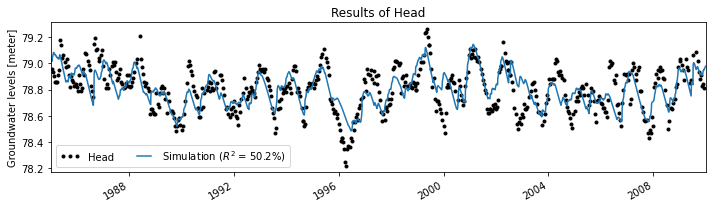

In [4]:
ml1 = ps.Model(head)
sm1 = ps.RechargeModel(prec, evap, recharge=ps.rch.FlexModel(),
                      rfunc=ps.Gamma, name="rch")
ml1.add_stressmodel(sm1)

# As the evaporation used is a very rough estimation, vary k_v
ml1.set_parameter("rch_kv", vary=True)

# Solve the Pastas model in two steps
ml1.solve(tmin=tmin, tmax=tmax, noise=False, fit_constant=False, report=False)
ml1.set_parameter("rch_srmax", vary=False)
ml1.solve(tmin=tmin, tmax=tmax, noise=True, fit_constant=False, initial=False)
ml1.plot(figsize=(10,3));

The model fit with the data is not too bad, but we are clearly missing the highs and lows of the observed groundwater levels. This could have many causes, but in this case we may suspect that the occurence of snowfall and melt impacts the results.

## 3. Account for snowfall and snow melt

A second model is now created that accounts for snowfall and melt through a degree-day snow model (see e.g., Kavetski & Kuczera (2007). To run the model we add the keyword `snow=True` to the `FlexModel` and provide a time series of mean daily temperature to the `RechargeModel`. The temperature time series is used to split the precipitation into snowfall and rainfall.

In [5]:
ml2 = ps.Model(head)
sm2 = ps.RechargeModel(prec, evap, recharge=ps.rch.FlexModel(snow=True),
                      rfunc=ps.Gamma, name="rch", temp=temp)
ml2.add_stressmodel(sm2)

# As the evaporation used is a very rough estimation, vary k_v
ml2.set_parameter("rch_kv", vary=True)

# Solve the Pastas model in two steps
ml2.solve(tmin=tmin, tmax=tmax, noise=False, fit_constant=False, report=False)
ml2.set_parameter("rch_srmax", vary=False)
ml2.solve(tmin=tmin, tmax=tmax, noise=True, fit_constant=False, initial=False)

Fit report Head                       Fit Statistics
nfev    227                    EVP             46.24
nobs    590                    R2               0.46
noise   True                   RMSE             0.12
tmin    1985-01-01 00:00:00    AIC          -3329.53
tmax    2010-01-01 00:00:00    BIC          -3290.11
freq    D                      Obj              1.01
warmup  3650 days 00:00:00     ___                  
solver  LeastSquares           Interp.            No

Parameters (9 optimized)
                 optimal   stderr     initial   vary
rch_A           1.116871   ±8.42%    0.821786   True
rch_n           1.280022   ±1.56%    1.499882   True
rch_a         165.623472   ±8.88%  111.563596   True
rch_srmax       8.076455    ±nan%    8.076455  False
rch_lp          0.250000    ±nan%    0.250000  False
rch_ks       1389.482377  ±56.41%  209.493220   True
rch_gamma      19.751299   ±9.57%   12.076045   True
rch_kv          1.847559   ±0.52%    1.539094   True
rch_simax       2.00

## Compare results
From the `fit_report` we can already observe that the model fit improved quite a bit. We can also  visualize the results to see how the model improved.

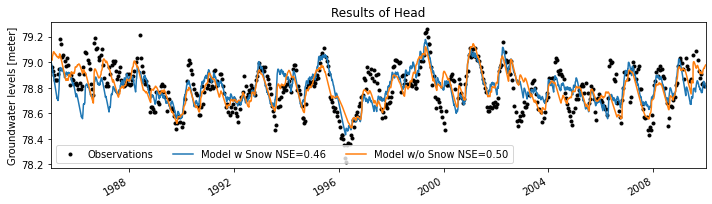

In [6]:
ax = ml2.plot(figsize=(10,3));
ml1.simulate().plot(ax=ax)
plt.legend(["Observations", "Model w Snow NSE={:.2f}".format(ml2.stats.nse()), 
            "Model w/o Snow NSE={:.2f}".format(ml1.stats.nse())], ncol=3)

## Extract the water balance (States & Fluxes)

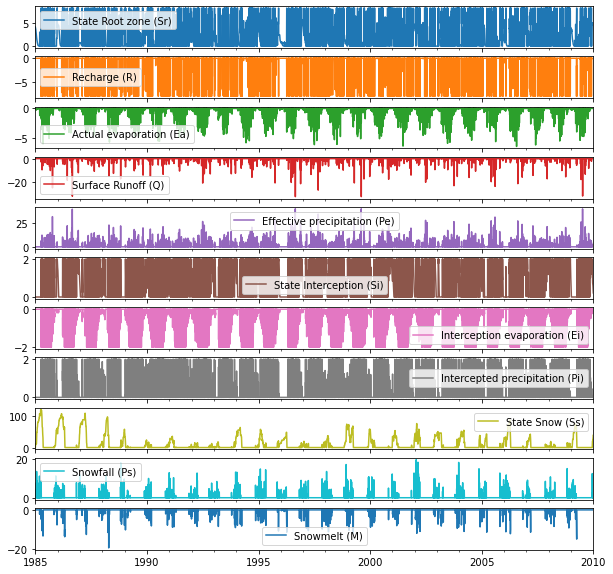

In [7]:
df = ml2.stressmodels["rch"].get_water_balance(ml2.get_parameters("rch"), tmin=tmin, tmax=tmax)
df.plot(subplots=True, figsize=(10, 10));

## References

- Kavetski, D. and Kuczera, G. (2007). Model smoothing strategies to remove microscale discontinuities and  spurious secondary optima  in  objective  functions  in  hydrological calibration. Water Resources Research, 43(3).